# Google Analytics Revenue Prediction

## Model Selection

**Environment**

In [75]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
from myfunctions import *

**Import Dataframe**

In [3]:
df = pd.read_csv("data/df5-1.csv", low_memory=False)

In [4]:
df.shape

(903455, 50)

In [5]:
df.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,oc_Android,oc_Macintosh,oc_Windows,oc_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,newConversion
0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.250794,0
1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.296152,0
2,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.139626,0
3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.132513,0
4,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,1,0,1,0,1,0.719945,0


### Model Selection

In the model selection process I will take into account:<br>
    1.- It is a binaty classification problem<br>
    2.- The data is Sparse<br>
    3.- The target is very unbalanced (1,29% vs 98,71)<br>
    4.- There is a lot of data 903455 rows and 48 columns<br>

**CONCLUSIONS:**<br>
1.- I'll use a decision tree<br>
2.- I'll try to balance the classes down sampling the data<br>
3.- I'll use Under ROC Curve (AUROC) as metric<br>

### Down sampling the dataframe

I'll separate observations from each class into different DataFrames.


In [6]:
# Separate majority and minority classes
df_majority = df[df.newConversion==0]
df_minority = df[df.newConversion==1]

In [7]:
df_majority.shape

(891940, 50)

In [8]:
df_minority.shape

(11515, 50)

I'll resample the majority class without replacement, setting the number of samples to match that of the minority class.


In [9]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=11515,     # to match minority class
                                 random_state=123) # reproducible results
 

I'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.

In [10]:
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [11]:
df_downsampled['newConversion'].value_counts()

1    11515
0    11515
Name: newConversion, dtype: int64

In [12]:
df_downsampled.shape

(23030, 50)

In [13]:
df_downsampled.isnull().sum().sum()

0

### Classification Tree: Random Forrest

#### Split dataframe

In [14]:
X = df_downsampled.iloc[:,:-1]
y = df_downsampled.iloc[:,-1:]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, test_size=0.2, random_state=10)

#### Search Grid Cross Validation

In [16]:
rfc = RandomForestClassifier(random_state=10)

In [17]:
#Current parameters of Random Forrest Classifier
print(rfc.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


I'll use the following parameters to hypertune the model

n_estimators = number of trees in the foreset<br>
max_features = max number of features considered for splitting a node<br>
max_depth = max number of levels in each decision tree<br>
bootstrap = method for sampling data points (with or without replacement)<br>
criterion = the function to measure the quality of a split

In [18]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'bootstrap' : [True, False],
    'criterion': ['gini', 'entropy']   
}

In [19]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=1)

In [20]:
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selectio

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [21]:
CV_rfc.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100}

In [22]:
rfc_best=RandomForestClassifier(random_state=10, max_features=CV_rfc.best_params_['max_features'], n_estimators=CV_rfc.best_params_['n_estimators'], max_depth=CV_rfc.best_params_['max_depth'], criterion=CV_rfc.best_params_['criterion'], bootstrap=CV_rfc.best_params_['bootstrap'])


In [23]:
rfc_best.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [24]:
rfc_best.feature_importances_

array([3.94619344e-04, 5.82297562e-04, 1.95367465e-02, 1.17737935e-04,
       3.23309021e-05, 2.10033278e-03, 4.58234554e-05, 1.00050924e-04,
       8.54936103e-05, 7.80904444e-03, 4.11346103e-03, 1.25218960e-03,
       5.19319361e-03, 1.69382045e-03, 2.16104720e-03, 5.96733527e-05,
       9.00643393e-02, 2.31992258e-02, 1.81225732e-02, 2.34148124e-04,
       5.53711995e-05, 1.90807014e-05, 1.76909161e-04, 1.31987965e-04,
       7.09037358e-05, 3.55804002e-04, 5.03163028e-05, 3.54861940e-04,
       8.15454747e-05, 2.58407885e-05, 5.49991129e-04, 5.22370302e-04,
       1.42108036e-06, 2.00457528e-04, 3.41664629e-02, 6.04805130e-03,
       3.05019484e-02, 2.06292714e-03, 3.89005925e-02, 1.61920618e-02,
       2.04167878e-04, 3.66388264e-02, 5.79831829e-03, 1.17798281e-01,
       2.51598531e-02, 5.00269095e-01, 1.59195596e-04, 5.79609104e-03,
       8.09118112e-04])

In [66]:
def plot_feat_imp(model, number,predictors):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    feat_imp = feat_imp[0:number]
    name = []
    for i in feat_imp.index.tolist():
        name.append(predictors[i])
        feat_imp.plot(kind='bar', title='Feature Importance')
    plt.xticks(range(0, len(feat_imp)),name, rotation='vertical')
    plt.ylabel('Feature Importance Score')
    plt.show()

def print_feat_imp(model, df):
    names = df.columns
    features = sorted(zip(map(lambda x: round(x, 4), rfc_best.feature_importances_), names), reverse=True)
    feat = pd.DataFrame(features)
    feat.columns = ['Importance', 'Feature']
    return feat

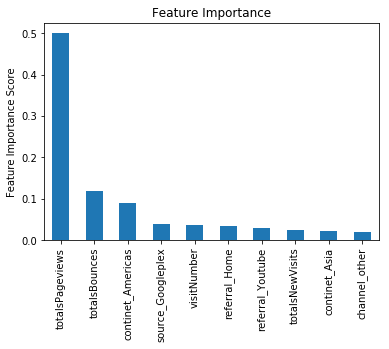

In [67]:
plot_feat_imp(rfc_best,10,df_downsampled.columns)

In [68]:
print_feat_imp(rfc_best,df_downsampled)

,Importance,Feature
0,0.5003,totalsPageviews
1,0.1178,totalsBounces
2,0.0901,continet_Americas
3,0.0389,source_Googleplex
4,0.0366,visitNumber
5,0.0342,referral_Home
6,0.0305,referral_Youtube
7,0.0252,totalsNewVisits
8,0.0232,continet_Asia
9,0.0195,channel_other


In [ ]:
newRandom

In [40]:
y_pred_train=rfc_best.predict(X_train)

In [37]:
y_pred=rfc_best.predict(X_test)

In [41]:
f1_score(y_train, y_pred_train)

0.9597379266617353

In [38]:
f1_score(y_test, y_pred)

0.9595424698157169

In [42]:
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[8580,  629],
       [ 133, 9082]])

In [39]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2150,  156],
       [  35, 2265]])

In [70]:
roc_auc_score(y_test, y_pred)

0.9585664994909311

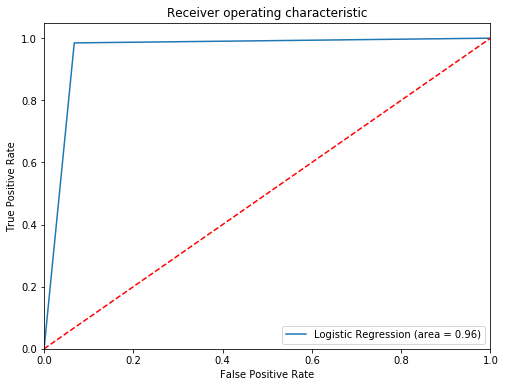

In [71]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [79]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [85]:
y.head()

,newConversion
106412,0
36727,0
225787,0
574945,0
824616,0


In [78]:
class_names = [1,0]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')



TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')